# PHY438 mini-project
## Constructing a galaxy luminosity function


April 2023, Reg: 210193123

### Initialisations

In [1]:
# MODULE INCLUDES

import numpy as np
from astropy import units as u
from astropy.cosmology import units as cu
from astropy.cosmology import Planck18
from astropy.coordinates import Distance
from astropy.io import ascii
from astropy.modeling.powerlaws import Schechter1D
from astropy.table import Table, Column
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from cycler import cycler

import time
thetime = time.time()

In [2]:
# CONSTANTS

LimitingMag = 22 * u.mag
CatSkyArea = 10 * u.deg**2  # sky survey size
zLimit = 0.1 * cu.redshift

# Best practice, avoid hard-coded values in code body,
# especially external file headers.
Redshift = 'Redshift'  # z
AppMag = 'K-band mag'  # apparent magnitude K-Band, m
DAppMag = 'K-band dmag'  # uncertainty on m 
LumDst = 'LumDst'  # luminosity distance, dL
AbsMag = 'K-band absmag' # absolute magnitude K-Band, M
DAbsMag = 'K-band dabsmag'  # uncertainty on M

In [3]:
# MATPLOTLIB STYLE
# (this would normally be in a text file)
# Some of this style was taken from an example
# .style() text file, but stripped, amended, and
# ported to this dict format by me.
plt.rcParams.update({
    'xtick.color': '#323034',
    'ytick.color': '#323034',
    'text.color': '#323034',
    'font.size': 12,
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    'lines.linewidth': 2,
    'axes.prop_cycle': cycler('color',['c', 'm', 'y', 'k']),
    'legend.frameon': False,
    'legend.fontsize': 12,
    'legend.borderpad': 0.6,
    'legend.columnspacing': 1.5,
    'legend.labelspacing':  0.4,
    'axes.formatter.use_mathtext': True,
    'axes.labelpad': 3,
    'axes.labelcolor': 'black',
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.6,
    'ytick.right': True,
    'xtick.top': True,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 4,
    'ytick.major.size': 6,
    'xtick.minor.size': 2,
    'ytick.minor.size': 3,
    'figure.dpi': 150, # for web, for print ~300
    'figure.figsize': (5.5,5.5),
    'lines.markeredgecolor': 'k',
    'lines.markeredgewidth': 0.5,
    # for these plots
    'axes.xmargin': 0.1,
    'axes.ymargin': 0.05,
    })
# print(plt.rcParams)

In [4]:
# DATA LOAD

# import CSV file to astropy Table & verify total lines
Cat = ascii.read('Survey.csv', format='csv')

# impart astropy.units to columns
Cat[Redshift].unit = cu.redshift
Cat[AppMag].unit = u.mag
Cat[DAppMag].unit = u.mag

# verify
print(f'{len(Cat)} data lines loaded, header: {Cat.colnames}')

59977 data lines loaded, header: ['Redshift', 'K-band mag', 'K-band dmag']


### Part 1.
*remove any non-robustly detected galaxies from their catalogue;*

*The survey covers 10 square degrees and has a limiting apparent
magnitude of 22 mag. This means that a galaxy with an apparent K-band magnitude of 22 mag
would be detected at the 1σ level. Note that detections below 3σ (i.e., in this case fainter than
22 − 2.5 log10(3) ≈ 20.8) are not considered robust and should therefore not be included in the
analysis.*

#### Answer follows:

In [5]:
# Calculate robust catalogue mag limit for 3sigma
robust_magnitude_limit = LimitingMag - 2.5*np.log10(3)*u.mag

# Select rows with apparent mag above robust mag limit and remove.
# Remove rows in this instance seems ~300us slower than a mask
# select. As I'm doing mask select later, and this dataset is
# so small, I'm showing this technique on this set of data.
Cat.remove_rows(Cat[AppMag] > robust_magnitude_limit)

print(len(Cat))

34603


### Part 2.
*produce a plot showing the number counts of the robustly-detected galaxies in their catalogue;*

*Note: This step is, in principle, not specifically required to generate a luminosity function, but it is good practice to do so.*

#### Answer follows:

As will be discussed in Part 8, I'm assuming poission distribution for errors, and as published charts don't appear to have titles (unless differentiating e.g. surveys) I won't put one on.

In [6]:
# 0.5 mag isn't a unit (please tell me if it is)
half_mag = u.def_unit('0.5 mag', 0.5 * u.mag)

# construct galaxy number count N/deg2/0.5mag
bin_count, bin_count_lims = np.histogram(Cat[AppMag], bins=30)
# Poisson => sigma(bin) = sqrt(Count of bin)
bin_count_err = np.sqrt(bin_count) * u.ct
# apply units
bin_count *= u.ct
bin_count_lims *= u.mag

# calculate bin width
bin_count_width = bin_count_lims[1] - bin_count_lims[0]

# define x values (mag)
mag_bins = bin_count_lims[:-1]+bin_count_width/2  # x, centre of bin
# define y values (count / 0.5 mag / deg2)
num_count = bin_count / bin_count_width.to(half_mag) / CatSkyArea
num_count_err = bin_count_err / bin_count_width.to(half_mag) / CatSkyArea

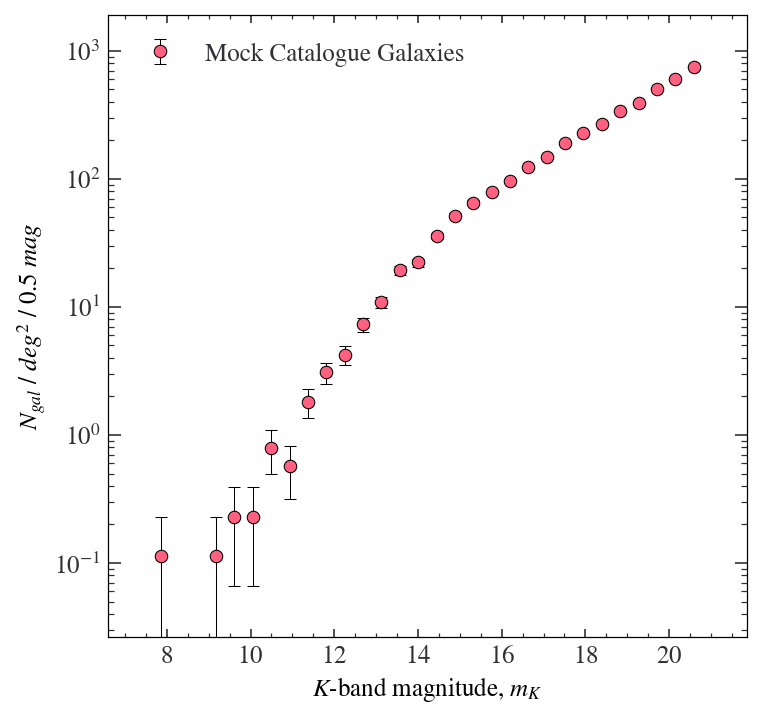

In [7]:
# set up plot
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_ylabel("$N_{gal}~/~deg^2~/~0.5~mag$")
ax.set_xlabel("$K$-band magnitude, $m_K$")

ax.errorbar(
    mag_bins,
    num_count,
    yerr=num_count_err,
    fmt='o',
    color='#ff6080',
    capsize=3,
    elinewidth=0.5,
    ecolor='k',
    label = 'Mock Catalogue Galaxies',
    )


# show plot and close
ax.set_ymargin(0.1)
# ax.set_title("Galaxy Number Count")
ax.legend(loc='upper left')
plt.show()
plt.close()

### Part 3.
*select only z < 0.1 galaxies;*

#### Answer follows:

In [8]:
# Depending on size, memory, reuse, etc,
# there are many ways to skin this Cat.

# in this case...
# create subcatalogue at less than z limit, leaving original
SubCat = Cat[Cat[Redshift] < zLimit]

print(len(SubCat))

8994


### Part 4.
*calculate the volume of the z < 0.1 Universe covered by their survey, assuming a Planck 2018
cosmology;*

#### Answer follows:

I need practice... sooooo......

Volume spherical sector, $V_s$, between radii $r_1$, $r_2$, given surface area of spherical cap at the radius, $A_c(r)$,

$$V_s = \int_{r_1}^{r_2} A_c(r)~dr.$$

Area of a spherical cap with angular radius $\theta$,

$$A_c(r) = 4 \pi r^2~(1-cos \theta)$$

As $(1-cos \theta) \equiv$ cap surface area/sphere surface area, given angular cap surface area in sq degr, $X$,

$$\implies A_c(r) = 4 \pi r^2~\frac{X}{4\pi(180/\pi)^2}$$

$$\implies A_c(r) = \frac{\pi^2~X}{32400}~r^2.$$

Adding into $V_s$,

$$\implies V_s = \frac{\pi^2~X}{32400}~\int_{r_1}^{r_2} r^2~dr$$

$$\implies V_s = \frac{\pi^2~X}{32400}.\frac{1}{3}.\left[{r_2^3}-{r_1^3}\right]$$

In our case, $r_1 \rightarrow r_2 = 0 \rightarrow d_p$, where $X$ is in deg sq,

$$\therefore V_s = \frac{\pi^2~X~d_p^3}{97200}$$

$$units:~V_s~Mpc^3 = \frac{\pi^2}{97200}~deg^{-2}.~X~deg^{2}~(d_p~Mpc)^3$$

This appears equivalent to the formulae provided in the tips, and is quite clear in this simple case as it's just the volume of a sphere to the proportion of viewed angular sky area/total angular area.

In [9]:
print(Planck18)

# calculate comoving distance at zLimit,
# which is equal to proper distance at now, t=0, a=1
dp_zLimit = Planck18.comoving_distance(zLimit)

# calculate volume spherical sector catalog sky survey area and z limit(as dp)
# Vol[Mpc3] = (pi**2/97200)[deg-2] * sky-area[deg2] * proper-distance[Mpc]**3
SubCat_vol = (np.pi**2/97200)*u.deg**-2 * CatSkyArea * dp_zLimit**3


print(f'dp(z={zLimit}) = {dp_zLimit:.2f}\n'
      f'Vs dp(z={zLimit}) @ {CatSkyArea}: {SubCat_vol:.0f}'
     )

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)
dp(z=0.1 redshift) = 432.57 Mpc
Vs dp(z=0.1 redshift) @ 10.0 deg2: 82184 Mpc3


### Part 5.
*calculate the luminosity distance of each z < 0.1 galaxy in their catalogue, again assuming a
Planck 2018 cosmology;*

#### Answer follows:

In [10]:
# use astropy.cosmology.Distance class zith z and Planck18 cosmology
# to calculate luminosity distances (and also distance moduli!)
# https://docs.astropy.org/en/stable/api/astropy.coordinates.Distance.html
subcat_distance = Distance(z=SubCat[Redshift], cosmology=Planck18)
print(subcat_distance)

# I thought I could store classes in Columns, but storing this just
# flattens the data to luminosity distance array.. ?? Need for Part 6.

[297.16468092 385.49054534 360.7525771  ... 306.8782986  187.29019572
 220.37093298] Mpc


### Part 6.
*calculate the absolute magnitude of each z < 0.1 galaxy in their catalogue, including errors;*

#### Answer follows:

Still assuming Planck 2018.

In [11]:
# as we already have Distance class for all the galaxies, can just
# dump the distance modulus .dstmod to convert appmag to absmag
# distance modulus (distmod) = m - M => M = m - distmod
SubCat[AbsMag] = SubCat[AppMag] - subcat_distance.distmod

# distmod has no uncertainty as derived by z with no uncertainty
# single err propagation, Dq=(dq/dx).Dx => DM = (d(m-distmod)/dm).Dm = 1.Dm
SubCat[DAbsMag] = SubCat[DAppMag]

# print(SubCat[AbsMag])

### Part 7.
*calculate the limiting absolute magnitude of their survey;*

*To calculate the limiting absolute magnitude of the survey, calculate the absolute magnitude
of a galaxy that is just robustly detected at z = 0.1. Remember, a robust detection has a
flux that is at least 3 times the limiting flux of the survey.*

#### Answer follows:

Still assuming Planck 2018.

In [12]:
# Limiting absolute magnitude is just robustly detected at zLimit
# robust_magnitude_limit already calculated for 3sigma apparent mag.
# Distance modulus from astropy..Distance with Planck 2018 cosmo.
DM_zLimit = Distance(z=zLimit, cosmology=Planck18).distmod
# M = m - DM
limiting_abs_mag = robust_magnitude_limit - DM_zLimit

# further subcat the catalogue to remove all rows dimmer than lim abs mag
SubCat.remove_rows(SubCat[AbsMag]>limiting_abs_mag)
print(len(SubCat))

limiting_abs_mag

5875


<Quantity -17.58002695 mag>

### Part 8.
*create a plot showing the luminosity function of the z < 0.1 galaxies in their sample;*

#### Answer follows:

So to look nice, it would be great for the centres of bins to line up with whole mags.
However, how does that work for the limiting mag? There are 211 galaxies -17.5>absmag>limiting mag, so I need to use them all.

Also, searching on these charts seem to be a split on whether the magnitude increases with x or decreases with x. It doesn't look like there is a definitive answer. While my OCD side would want increasing brightness with increasing x, the 'line goes up' chart is more inviting to look at from a presentation point of view, so I'll do that.

Errors... assuming a Poisson distribution ($\sigma_{bin} = \sqrt{N_{bin}}$) as Schechter 1976 did as I'm struggling to find any information on how the observation errors (for which the mean is 0.06 mag?) would otherwise massively affect the binning process.

In [13]:
# Create histogram of SubCat
SubCat_count, SubCat_bins = np.histogram(SubCat[AbsMag], bins=20)
# Poisson => sigma(bin) = sqrt(Count of bin)
SubCat_count_err = np.sqrt(SubCat_count) * u.ct
# apply units
SubCat_count *= u.ct
SubCat_bins *= u.mag


#SubCat_cumsum = np.cumsum(SubCat_count)
SubCat_bins_width = SubCat_bins[1] - SubCat_bins[0]

# x values centred on bins
SubCat_M = SubCat_bins[:-1]+SubCat_bins_width/2
# y values
SubCat_phi = SubCat_count / SubCat_bins_width / SubCat_vol
SubCat_phi_err = SubCat_count_err / SubCat_bins_width / SubCat_vol

In [14]:
# define repeatable plot scripts
# set up plot
def common_subplots_setup():
    plt.close('all')
    fig, ax = plt.subplots()
    ax.set_ylabel("$\phi$ $[~N~/~mag~/~Mpc^3~]$")
    ax.set_xlabel("$K$-band absolute magnitude, $M_K$")
    ax.set_yscale("log")
    return fig, ax

# common plot for error bar (with optional connecting lines)
def common_subplots_errorbar(line=False):
    handle_error = \
        ax.errorbar(
            SubCat_M,
            SubCat_phi,
            yerr=SubCat_phi_err,
            fmt='s-' if line else 's',  # optional line
            capsize=3,
            elinewidth=0.5,
            ecolor='k',
            zorder=4  # bring to front
            )
    label_error = 'Mock Catalogue Galaxies, $z<0.1$'
    return handle_error, label_error

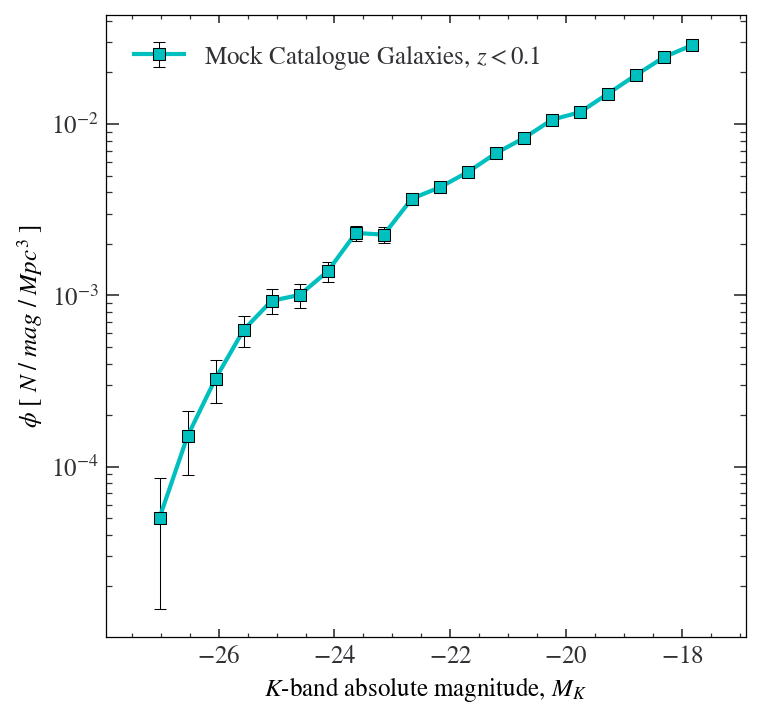

In [15]:
# set up plot and draw errorbar plot (with joining lines)
fig, ax = common_subplots_setup()
handle_ebar, label_ebar = common_subplots_errorbar(line=True)

# show plot and close
ax.legend([handle_ebar], [label_ebar], loc='upper left')
# ax.set_title("Luminosity Function") published plots don't use titles this way
plt.show()
plt.close()

### Part 9.
*it a Schechter function to their z < 0.1 luminosity function, plot the best-fitting Schechter function on their lumi-
nosity function, and report the best-fitting values of M ∗, φ∗ and α, including uncertainties.*

#### Answer follows:

In [16]:
# had to upgrade astropy-5.0.1->5.2.2 for this one
# Schechter1D(phi_star=1.0, m_star=-20.0, alpha=-1.0)

# obtain best fit for Schechter function
popt, pcov = \
    curve_fit(
        f=lambda x,a,b,c: Schechter1D(phi_star=a, m_star=b, alpha=c)(x),
        xdata=SubCat_M,
        ydata=SubCat_phi,
        sigma=SubCat_phi_err,
        p0 = [0.001, -25.9, -1.4],  # experimented with rough-fit values
        bounds=([0., -40, -3.0],    # set a reasonable range
                [1,  -20, -0.7]),
        )
# calculate sigma from covariance
perr = np.sqrt(np.diag(pcov))
# set indices for popt, perr arrays
phi_star = 0
m_star = 1
alpha = 2

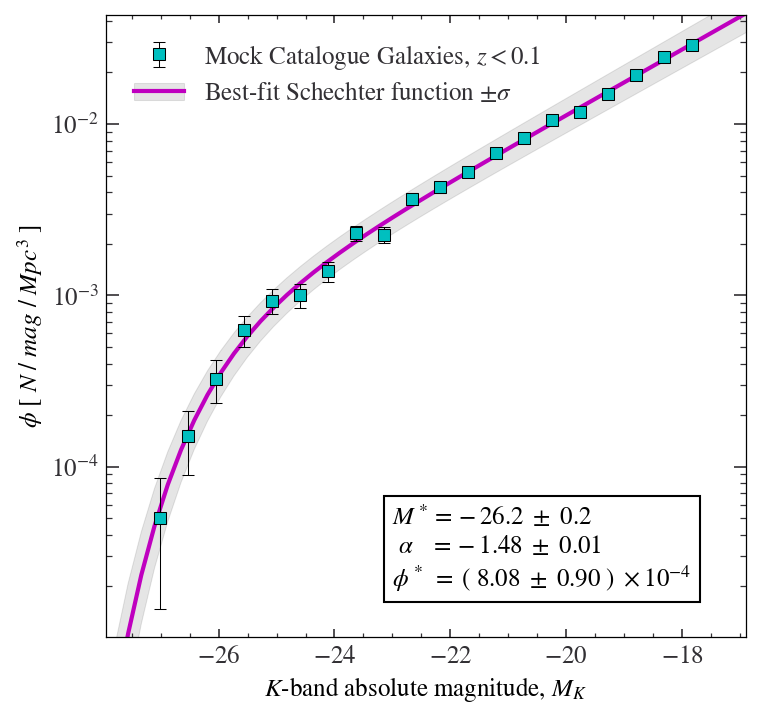

In [17]:
# set up plot and draw errorbar plot
fig, ax = common_subplots_setup()
handle_ebar, label_ebar = common_subplots_errorbar()

# fix x,y lims here
ax.set_ylim(ax.get_ylim())
ax.set_xlim(ax.get_xlim())  # [::-1] would reverse

# create high-res set of x values for Schechter function
x_linspace = np.linspace(
                SubCat_M[0]-1*u.mag,
                SubCat_M[-1]+1*u.mag,
                50
                ).value

# draw bestfit error-bar area as fill-between, save legend handle.
handle_schsig = \
    ax.fill_between(
        x_linspace,
        # upper bound (note +/- error combination)
        Schechter1D(phi_star=popt[phi_star] + perr[phi_star],
                    m_star=popt[m_star] - perr[m_star],
                    alpha=popt[alpha] - perr[alpha]
                   )(x_linspace),
        # lower bound (note +/- error combination)
        Schechter1D(phi_star=popt[phi_star] - perr[phi_star],
                    m_star=popt[m_star] + perr[m_star],
                    alpha=popt[alpha] + perr[alpha]
                   )(x_linspace),
        linewidth=0.5,
        color='k',
        alpha=0.1
        )
# draw bestfit Schechter line, save legend handle & label.
handle_sch, = \
    ax.plot(
        x_linspace,
        Schechter1D(phi_star=popt[phi_star],
                    m_star=popt[m_star],
                    alpha=popt[alpha]
                   )(x_linspace),
        )
label_sch = "Best-fit Schechter function $\pm \sigma$"

# output best fit text box
phi_exp = -4
bestfit = (f"$M^*= {popt[m_star]:.1f}~\\pm~{perr[m_star]:.1f}$\n"  # L1
           f"$~\\alpha~~~= {popt[alpha]:.2f}~\\pm~{perr[alpha]:.2f}$\n"  # L2
           f"$\\phi^*~=~(~{popt[phi_star]*10**-phi_exp:.2f}~\\pm~" # L3 \
           f"{perr[phi_star]*10**-phi_exp:.2f}~)~\\times10^{{{phi_exp}}}$"
           )
ax.text(
    x=-23,  # manual config
    y=2e-5,
    s=bestfit,
    color='k',
    bbox=dict(facecolor='none', edgecolor='k'),
    )

# show plot and close
ax.legend(
    [handle_ebar, (handle_schsig, handle_sch)],  # stack line on fill legend
    [label_ebar, label_sch],
    loc='upper left'
    )
plt.show()
plt.close()

**Figure $n$.** Luminosity function of Sample Galaxy Catalogue in $K$-band to redshift $<0.1$. Cyan squares show observed data at the corresponding magnitude with Poisson distribution error bars. The purple line with grey uncertainty area shows best-fit Schechter function with $M^*=-26.2\pm0.2$, $\alpha = -1.48 \pm 0.01$, and $\phi^* = (8.08 \pm 0.90) \times 10^{-4}$.

In [18]:
print(time.time()-thetime)

1.5706555843353271


Getting ~1.5s on my single-core remote VM. I don't think I've lost too much time on the data processing side before doing the charts? Astropy units for practice though, will be more useful on far bigger datasets.